In [1]:
import kagglehub
import json
import us
import probablepeople as pp
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import *
from pyspark.sql.types import *
from wordcloud import WordCloud

# Contents - Findings: 
1. Load Dataset
   - Data is load from kaggle https://kaggle.com/datasets/e47f88e5e8ce59c9598475a107d9a80ebc363a83859a59facb069b13a9001773
     - Dataset is a semi structured JSON data with nested objects.
2. Data Transformation
   - Flatten JSON - flatten nested json columns ("personal_detail" and "personal_detail.address").
   - Clean Name Columns (person_name, merchant) - Remove unnecessary characters and split the name to "first" and "last" name for "person_name". Remove prefix "fraud_" for merchant names (it's best practice to include proper name for entity resolution with other datasets in the future).
3. Data Quality Assurance
   - Check for duplicates - No duplicated records.
   - Completeness - "cc_bic" and "merch_zipcode" has nulls. Any missing or invalid codes will be standardized to "NA" (transformed cc_bic field).
   - Accuracy - 
      - The columns 'amt' and 'city_pop' has no null or negative records (numerical fields).
      - The column 'is_fraud' has only 0 and 1 values.
      - The column 'merch_zipcode' has values with 5 characters long only. Also checked against python library ("us") to check if these zipcodes are legit - PASSED
      - The column 'state' has values with 2 characters long only.
      - The columns 'first' and 'last' names derived from 'person_name' is checked using NLP (probablepeople) to ensure it has proper US names - PASSED
      - The column 'category' has been checked manually and confirmed as proper categories.
      - The column 'job' is checked for invalid values. Generally seems like legit job/occupations except there are significant number of job with the title "Sub" - which can be too generic
   - Timeliness - Parse "merch_eff_time", "trans_date_trans_time", "merch_last_update_time" to legible datetime formats. "merch_eff_time" and "merch_last_update_time" has same values.
   - Schema validation - Transform the dataset based on the schema identified.
4. Descriptive Statistics
   - Dataset is imbalanced as most transactions (99.4%) is non-fraudulent transactions. May require additional transformation if this is to be fed to a predictive model.
   - Check for empty strings or nulls - 'cc_bic' has 11.13% records with empty strings, 'merch_zipcode' has 15.11% records which are nulls
5. Handling PII Data
   - Created new columns to mask PII data ("person_name" and "cc_id")unique hash ID using SHA-256 + added salt (random word)
6. Exploratory Data Analysis - subset of dataset (balanced records between fraudulent and non-fraudulent records is sampled)
   - Specific categories (like shopping_net, misc_net, grocery_pos, shopping_post) have higher ratios of fraudulent transactions (is_fraud = 1).
   - The amt column have a moderate positive correlation to the is_fraud field - which suggests higher transaction amounts associated with fraudulent transactions.
7. Fraud Risk Scenarios - to check columns for any apparent fraud risk
   - Check if One Person Has Multiple Credit Card - One person has only one credit card id in this dataset.
   - Check if One Credit Card Used by Multiple Persons - One credit card id is only used by one person in this dataset.
   - Check if multiple zip codes used by One Person - One person only has registered one zip code.
   - Check for Transactions from Distant Locations in Short Time (a.k.a. "Impossible Travel") using Harvesine formula
      - transactions (non-online transactions; categories without "_net" suffix) are performed > 200km within 1 hour time difference (compared to their previous transaction) are flagged
      - Finding: fraudulent transactions are usually associated with slightly higher distances (>220km)
   - Check if there's high frequency of transactions in short time
      - There are 79 cc_id with high frequency transactions (>=3) within 5 minutes
   - Check for Anomaly - Transactions 2x above 99th Percentile by categories
      - There are 807 records for transactions 2x above 99th percentile of the category
   - Check if Merchant Location Matches User Location
      - There are 0 records with distance mismatch between person_id and merch

Summary / Findings:
   - The name columns are extremely dirty but can be cleaned with relatively simple function.
   - The dataset is imbalanced with less than 1% of transactions are fraudulent transactions.
   - The dataset is masked using SHA-256 and it is a one-way irreversible transformation in this exercise - separated mapping tables is maintained to store the original PII along the hashed IDs.
   - From the sampled data, online transaction categories (like shopping_net, misc_net) have higher event rate for fraudulent activities - higher risk ratings for these categories.

In [2]:
# Initiate Spark Session
spark = SparkSession.builder.appName("cc_sample").getOrCreate()

your 131072x1 screen size is bogus. expect trouble
25/05/19 20:29:16 WARN Utils: Your hostname, sylxaen-pc resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/05/19 20:29:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/19 20:29:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# 1. Load Dataset from Kaggle

In [3]:
# Download latest version
path = kagglehub.dataset_download("jinquan/cc-sample-data")

In [4]:
# Load dataset
raw_df = spark.read.json(path)

In [5]:
# Check dtypes
raw_df.printSchema()

# NOTE: Currently 15 columns with one nested column, the expected columns have 26 columns

root
 |-- Unnamed: 0: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- category: string (nullable = true)
 |-- cc_bic: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_eff_time: string (nullable = true)
 |-- merch_last_update_time: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- personal_detail: string (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- trans_num: string (nullable = true)



# 2. Data Transformation

## Flatten JSON
- recursively flatten the nested json

In [6]:
# Function to dynamically infer the schema, parse JSON and flatten the cols 
def infer_and_parse_json(df, json_string_col, prefix: bool = False):
    # Step 1: Retrieve a sample of the JSON data - sample using first row to save compute
    sample_json = df.select(json_string_col).limit(1).collect()[0][0]
    
    # Step 2: Parse the JSON string into a dictionary
    parsed_json = json.loads(sample_json)
    
    # Step 3: Dynamically create the schema based on the JSON keys
    # All fields will be treated as StringType for now
    schema = StructType([StructField(key, StringType(), True) for key in parsed_json.keys()])
    
    # Step 4: Apply from_json to parse the column using the inferred schema
    df = df.withColumn(f"{json_string_col}_struct", from_json(col(json_string_col), schema))
    
    # Step 5: Flatten the struct into individual columns
    for field in schema.fields:
        if prefix:
            df = df.withColumn(f"{json_string_col}_{field.name}", col(f"{json_string_col}_struct.{field.name}"))
        else:
            df = df.withColumn(f"{field.name}", col(f"{json_string_col}_struct.{field.name}"))

    # Drop the original json string column and the intermediate struct column
    df = df.drop(json_string_col, f"{json_string_col}_struct")
    
    return df

# Flatten first json string col - personal_details
stg_df = infer_and_parse_json(df=raw_df, json_string_col="personal_detail", prefix=False)
# Flatten second/nested json string col - address in personal_details
stg_df = infer_and_parse_json(df=stg_df, json_string_col="address", prefix=False)
stg_df.show(truncate=False)

+----------+------+-------------+-----------+-------------------+--------+----------------+----------------------+------------------+------------------+-------------+----------------------------------------+---------------------+--------------------------------+-------------------------+------+-------+------------------+--------+---------------------------------------------+----------+------------------------------+------------------------+-----+-----+
|Unnamed: 0|amt   |category     |cc_bic     |cc_num             |is_fraud|merch_eff_time  |merch_last_update_time|merch_lat         |merch_long        |merch_zipcode|merchant                                |trans_date_trans_time|trans_num                       |person_name              |gender|lat    |long              |city_pop|job                                          |dob       |street                        |city                    |state|zip  |
+----------+------+-------------+-----------+-------------------+--------+------------

In [7]:
print(f"Number of columns for stg_df: {len(stg_df.columns)}")
# NOTE: This is 25/27 expected columns where it is missing "first" and "last" column (name)

Number of columns for stg_df: 25


## Name Derivations - Clean Names
- clean and split names from "person_name" and "merchant" accordingly

In [8]:
# Function to split the name column by all special characters - create first and last name columns
def split_person_name(df):
    # Split person_name by any non-alphanumeric character (special characters)
    # NOTE: this way, consecutive delimiters like "," will be considered as one, and will not take empty string as last name for example
    split_col = split(col("person_name"), "[^a-zA-Z0-9]+")
    
    # Create new columns "first" and "last" from the split, with trimming and capitalization
    df = df.withColumn("first", initcap(trim(split_col.getItem(0)))) \
           .withColumn("last", initcap(trim(split_col.getItem(1))))
    
    return df

# Apply the function to your DataFrame
stg_df = split_person_name(stg_df).drop("person_name")

# Show the resulting DataFrame
stg_df.show(truncate=False)

+----------+------+-------------+-----------+-------------------+--------+----------------+----------------------+------------------+------------------+-------------+----------------------------------------+---------------------+--------------------------------+------+-------+------------------+--------+---------------------------------------------+----------+------------------------------+------------------------+-----+-----+-----------+---------+
|Unnamed: 0|amt   |category     |cc_bic     |cc_num             |is_fraud|merch_eff_time  |merch_last_update_time|merch_lat         |merch_long        |merch_zipcode|merchant                                |trans_date_trans_time|trans_num                       |gender|lat    |long              |city_pop|job                                          |dob       |street                        |city                    |state|zip  |first      |last     |
+----------+------+-------------+-----------+-------------------+--------+----------------+---

25/05/19 20:29:33 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [9]:
# Clean up "merchant" name
# Check if the all the values have "fraud_" prefix 
stg_df.withColumn("merchant_clean", substring(col("merchant"), 1, 5)).groupBy("merchant_clean").count().show()
# NOTE: Yes all records have "fraud" prefix

# Clean up the merchant column
stg_df = stg_df.withColumn("merchant", split(col("merchant"), "fraud_").getItem(1))

+--------------+-------+
|merchant_clean|  count|
+--------------+-------+
|         fraud|1296675|
+--------------+-------+



# 3. Data Quality Assurance
1. Check for Duplicates:
    - Ensure that there are no repeated records in the dataset that could lead to skewed analysis or double counting.
    - Finding: No duplicated rows

2. Completeness:
    - Verify that all required fields and values are present and no critical data is missing (i.e. missing/null values or empty strings)
    - Finding: merch_zipcode has 195973 null values and cc_bic has 144381 records with empty strings

3. Accuracy:
    - Confirm that the data correctly represents real-world values and events without errors or inconsistencies.
    - Findings:
        - Numerical columns like "amt" and "city_pop" should not have negative values - PASSED
        - Boolean columns like "is_fraud" should have 0 or 1 values only - PASSED
        - Columns with standardized code like "state" should have only specific number of chars - PASSED: All values are 2 characters and checked against the directory for the states in the US.
        - Name columns like "first" and "last" name columns should consist actual names and not test datas - PASSED: All values are checked against NLP (probablepeople) for entity recognition
        - Categorical columns like "category" should have proper categories: PASSED

4. Timeliness:
    - Ensure that the data is up to date and available within the expected time frame for its intended use.
        - Findings: All datetime columns are loaded as string and parsing datetime string to datetime columns does not return error (and with proper date ranges)- PASSED

5. Schema Validation:
    - Check that the structure of the data (e.g., data types, field names, required columns) matches the defined schema or data model.
        - Transformation done: Defined all new schema and apply to the dataset

## Check for Duplicates

In [10]:
# Data Quality Check - Check for Duplicates
# Return records with duplicate values across all columns
stg_df.exceptAll(stg_df.dropDuplicates()).show()
# NOTE: Passed - 0 duplicate records

25/05/19 20:29:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/19 20:29:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/19 20:29:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/19 20:29:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/19 20:29:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/19 20:29:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/19 20:29:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/19 20:29:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/19 20:29:37 WARN RowBasedKeyValueBatch: Calling spill() on

+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+------+---+----+--------+---+---+------+----+-----+---+-----+----+
|Unnamed: 0|amt|category|cc_bic|cc_num|is_fraud|merch_eff_time|merch_last_update_time|merch_lat|merch_long|merch_zipcode|merchant|trans_date_trans_time|trans_num|gender|lat|long|city_pop|job|dob|street|city|state|zip|first|last|
+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+------+---+----+--------+---+---+------+----+-----+---+-----+----+
+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+------+---+----+--------+---+---+------+----+-----+---+-----+----+



## Completeness

In [11]:
stg_df.filter(col("merchant").isNull()).show()

+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+------+---+----+--------+---+---+------+----+-----+---+-----+----+
|Unnamed: 0|amt|category|cc_bic|cc_num|is_fraud|merch_eff_time|merch_last_update_time|merch_lat|merch_long|merch_zipcode|merchant|trans_date_trans_time|trans_num|gender|lat|long|city_pop|job|dob|street|city|state|zip|first|last|
+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+------+---+----+--------+---+---+------+----+-----+---+-----+----+
+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+------+---+----+--------+---+---+------+----+-----+---+-----+----+



In [12]:
# Data Quality Check - Completeness
# Check completeness: Count null values in each column
stg_df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in stg_df.columns)).show()

# NOTE: "merch_zipcode" has nulls

+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+------+---+----+--------+---+---+------+----+-----+---+-----+----+
|Unnamed: 0|amt|category|cc_bic|cc_num|is_fraud|merch_eff_time|merch_last_update_time|merch_lat|merch_long|merch_zipcode|merchant|trans_date_trans_time|trans_num|gender|lat|long|city_pop|job|dob|street|city|state|zip|first|last|
+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+------+---+----+--------+---+---+------+----+-----+---+-----+----+
|         0|  0|       0|     0|     0|       0|             0|                     0|        0|         0|       195973|       0|                    0|        0|     0|  0|   0|       0|  0|  0|     0|   0|    0|  0|    0|   0|
+----------+---+--------+------+------+--------+--------------+---------------------

In [13]:
# Data Quality Check - Completeness
# Check completeness: Count columns with empty string values in each column
stg_df.select(*(sum((col(c)=="").cast("int")).alias(c) for c in stg_df.columns)).show()

# NOTE: "cc_bic" has empty strings

+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+------+---+----+--------+---+---+------+----+-----+---+-----+----+
|Unnamed: 0|amt|category|cc_bic|cc_num|is_fraud|merch_eff_time|merch_last_update_time|merch_lat|merch_long|merch_zipcode|merchant|trans_date_trans_time|trans_num|gender|lat|long|city_pop|job|dob|street|city|state|zip|first|last|
+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+------+---+----+--------+---+---+------+----+-----+---+-----+----+
|         0|  0|       0|144381|     0|       0|             0|                     0|        0|         0|            0|       0|                    0|        0|     0|  0|   0|       0|  0|  0|     0|   0|    0|  0|    0|   0|
+----------+---+--------+------+------+--------+--------------+---------------------

In [14]:
stg_df.groupBy("cc_bic").count().show()
# NOTE: Seems like there's invalid values ("NA", "Null"). BIC/SWIFT Codes typically follows a pattern of 8 or 11 characters 

# Clean missing or invalids value and standardized to "NA"
invalid_cond = (
        col("cc_bic").isNull() |
        (lower(trim(col("cc_bic"))).isin(['', 'NA', 'null']))
    )

# NOTE: This is transformed into dim_df - which is going to be used for EDA but DQA stll checks using stg_df
dim_df = stg_df.withColumn("cc_bic", when(invalid_cond, lit("NA")).otherwise(col("cc_bic")))
dim_df.groupBy("cc_bic").count().show()

+-----------+------+
|     cc_bic| count|
+-----------+------+
|   ADMDUS41|143726|
|   ACEEUS31|144138|
|DEUTUS33TRF|144014|
|         NA|144385|
|CITIUS33CHI|143832|
|   AIABUS31|144457|
|           |144381|
|       Null|144214|
|   APBCUS61|143528|
+-----------+------+

+-----------+------+
|     cc_bic| count|
+-----------+------+
|   ADMDUS41|143726|
|   ACEEUS31|144138|
|DEUTUS33TRF|144014|
|         NA|432980|
|CITIUS33CHI|143832|
|   AIABUS31|144457|
|   APBCUS61|143528|
+-----------+------+



## Accuracy

In [15]:
# For numerical columns - check there's no negative values
for c in ["amt", "city_pop"]:
    null_or_negative_counts = stg_df.filter(col(c).cast("int") <= 0).count()
    if null_or_negative_counts > 0:
        print(f"The column {c} has {null_or_negative_counts} records")
    else:
        print(f"The column '{c}' has no null or negative records - PASSED")

The column 'amt' has no null or negative records - PASSED


The column 'city_pop' has no null or negative records - PASSED


In [16]:
# Check for boolean column - "is_fraud" to have 0 and 1 value only
stg_df.select("is_fraud").distinct().show()

# NOTE: PASSED - only 0 and 1

+--------+
|is_fraud|
+--------+
|       0|
|       1|
+--------+



In [17]:
# Check for zipcode to have only 5 characters only
stg_df.filter(col("merch_zipcode").isNotNull()).withColumn(
    "merch_zipcode_count", length("merch_zipcode")
).groupBy("merch_zipcode_count").count().show()
# NOTE: PASSED - non-null values only have 5 chars

+-------------------+-------+
|merch_zipcode_count|  count|
+-------------------+-------+
|                  5|1100702|
+-------------------+-------+



In [18]:
# Check for state code to have only 2 characters only
stg_df.filter(col("state").isNotNull()).withColumn(
    "state_count", length("state")
).groupBy("state_count").count().show()
# NOTE: PASSED - non-null values only have 2 chars

+-----------+-------+
|state_count|  count|
+-----------+-------+
|          2|1296675|
+-----------+-------+



In [19]:
# Use python library "us" to check if the state codes are legit
states_list = [str(state_code) for state_code in stg_df.select("state").distinct().collect()]
illegible_state_codes = [us.states.lookup(state_code) for state_code in states_list if us.states.lookup(state_code)]
illegible_state_codes
# NOTE: PASSED - All state codes are legit

[]

In [20]:
## Check if first names are legit US names using Python Library/NLP - probablepeople
def label_names(text: str):
    # Label using the probablepeople library - returns the tab either Person or Corporation
    return pp.tag(text)[-1]

udf_label_names = udf(lambda x: label_names(x), returnType=StringType())

agg_first_names = stg_df.groupBy("first").count().sort(desc("count")).withColumn("label", udf_label_names(col("first")))
agg_first_names.show()

agg_first_names.filter(col("label")!= "Person").show()

# NOTE: PASSED - All first names are proper US-names

+-----------+-----+------+
|      first|count| label|
+-----------+-----+------+
|Christopher|26669|Person|
|     Robert|21667|Person|
|    Jessica|20581|Person|
|      James|20039|Person|
|    Michael|20009|Person|
|      David|19965|Person|
|   Jennifer|16940|Person|
|    William|16371|Person|
|       Mary|16346|Person|
|       John|16325|Person|
|   Margaret|15312|Person|
|     Joseph|14792|Person|
|     Daniel|13867|Person|
|       Lisa|13767|Person|
|     Amanda|13310|Person|
|     Ashley|13296|Person|
|    Jeffrey|12831|Person|
|   Michelle|12601|Person|
|     Samuel|12179|Person|
|   Kimberly|11815|Person|
+-----------+-----+------+
only showing top 20 rows



+-----+-----+-----+
|first|count|label|
+-----+-----+-----+
+-----+-----+-----+



In [21]:
## Check if last names are legit US names using Python Library/NLP - probablepeople
agg_last_names = stg_df.groupBy("last").count().sort(desc("count")).withColumn("label", udf_label_names(col("last")))
agg_last_names.show()

agg_last_names.filter(col("label")!= "Person").show()

+---------+-----+------+
|     last|count| label|
+---------+-----+------+
|    Smith|28794|Person|
| Williams|23605|Person|
|    Davis|21910|Person|
|  Johnson|20034|Person|
|Rodriguez|17394|Person|
| Martinez|14805|Person|
|    Jones|13976|Person|
|    Lewis|12753|Person|
| Gonzalez|11799|Person|
|   Miller|11698|Person|
|     Lowe|11308|Person|
|   Martin|11252|Person|
|     Bell|10784|Person|
|    Perez| 9729|Person|
| Robinson| 9287|Person|
|   Bishop| 9254|Person|
|   Garcia| 9186|Person|
|  Mendoza| 8763|Person|
|   Thomas| 8724|Person|
|    Clark| 8715|Person|
+---------+-----+------+
only showing top 20 rows



+----+-----+-----+
|last|count|label|
+----+-----+-----+
+----+-----+-----+



In [22]:
# Check if categorical column - category is proper
stg_df.groupBy("category").count().show()

# NOTE: Passed

+--------------+------+
|      category| count|
+--------------+------+
|        travel| 40507|
|      misc_net| 63287|
|   grocery_pos|123638|
|     kids_pets|113035|
|  shopping_net| 97543|
|   grocery_net| 45452|
|   food_dining| 91461|
| gas_transport|131659|
| personal_care| 90758|
|health_fitness| 85879|
| entertainment| 94014|
|          home|123115|
|      misc_pos| 79655|
|  shopping_pos|116672|
+--------------+------+



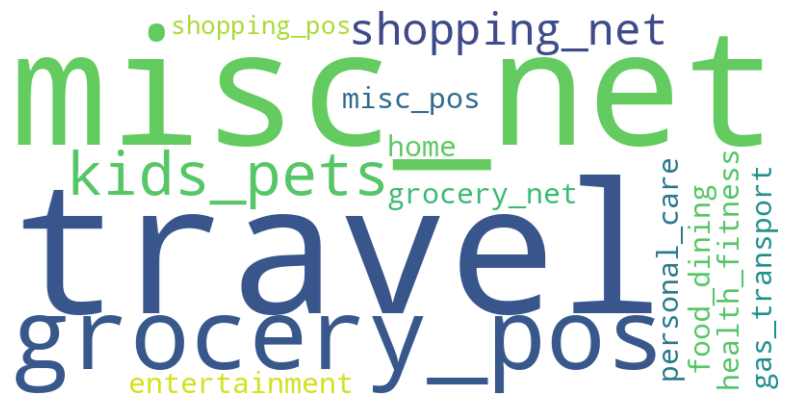

In [23]:
# Collect the text column values to driver as a list
text_list = stg_df.select("category").distinct().rdd.flatMap(lambda x: x).collect()

# Combine all texts into one string
text = " ".join([str(t) for t in text_list if t])  # Remove nulls

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [24]:
# Check if categorical column - job is proper
stg_df.groupBy("job").count().sort(desc("count")).show()
# NOTE: There is significant number of job with the title "Sub" - which is to generic and may require further clarification

+--------------------+-----+
|                 job|count|
+--------------------+-----+
|   Film/video editor| 9779|
| Exhibition designer| 9199|
|     Naval architect| 8684|
|Surveyor, land/ge...| 8680|
|  Materials engineer| 8270|
|Designer, ceramic...| 8225|
|   Systems developer| 7700|
|          IT trainer| 7679|
|   Financial adviser| 7659|
|Environmental con...| 7547|
|Chartered public ...| 7210|
|Scientist, audiol...| 7174|
|Chief Executive O...| 7172|
|Copywriter, adver...| 7146|
|         Comptroller| 6730|
|                 Sub| 6701|
|          Podiatrist| 6653|
|Agricultural cons...| 6642|
|           Paramedic| 6635|
|Magazine features...| 6602|
+--------------------+-----+
only showing top 20 rows



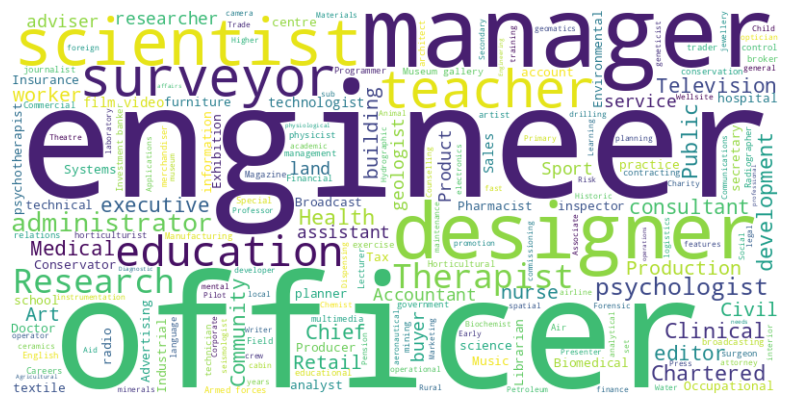

In [25]:
# Collect the text column values to driver as a list
text_list = stg_df.select("job").distinct().rdd.flatMap(lambda x: x).collect()

# Combine all texts into one string
text = " ".join([str(t) for t in text_list if t])  # Remove nulls

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Timeliness


### Timestamp Conversion - Parse Datetime

In [26]:
# Parse datetime string to datetime cols - including dob to be date col
datetime_cols = ["merch_eff_time", "trans_date_trans_time", "merch_last_update_time"]

stg_df = stg_df.withColumns(
    {
        colname: from_utc_timestamp(
            to_timestamp(col("trans_date_trans_time"), "yyyy-MM-dd HH:mm:ss"),
            "Asia/Singapore",
        )
        for colname in datetime_cols
    }
).withColumn("dob", to_date(col("dob"), "yyyy-MM-dd")) # Parse DOB to date

In [27]:
# Check the date range for all datetime columns
for c in [*datetime_cols, "dob"]:
    print(f"The date range for column '{c}' is {stg_df.select(min(c)).collect()[0][0].strftime("%Y-%m-%d")} to {stg_df.select(max(c)).collect()[0][0].strftime("%Y-%m-%d")}")


# NOTE: The date range seems normal for datetime cols - PASSED

The date range for column 'merch_eff_time' is 2019-01-01 to 2020-06-21


The date range for column 'trans_date_trans_time' is 2019-01-01 to 2020-06-21


The date range for column 'merch_last_update_time' is 2019-01-01 to 2020-06-21


The date range for column 'dob' is 1924-10-30 to 2005-01-29


### Check merch columns

In [28]:
# Check the difference between merch_eff_time and merch_last_update_time
stg_df.withColumn("is_same_merch_time", col("merch_eff_time")== col("merch_last_update_time")).filter(col("is_same_merch_time")==False).show()
# NOTE: Seems like these two times have exact same values

+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+------+---+----+--------+---+---+------+----+-----+---+-----+----+------------------+
|Unnamed: 0|amt|category|cc_bic|cc_num|is_fraud|merch_eff_time|merch_last_update_time|merch_lat|merch_long|merch_zipcode|merchant|trans_date_trans_time|trans_num|gender|lat|long|city_pop|job|dob|street|city|state|zip|first|last|is_same_merch_time|
+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+------+---+----+--------+---+---+------+----+-----+---+-----+----+------------------+
+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+------+---+----+--------+---+---+------+----+-----+---+-----+----+------------------+



## Schema validation 
- Convert columns to appropriate dtypes

In [29]:
new_schema = StructType(
    [
        StructField("Unnamed: 0", StringType(), True),
        StructField("amt", StringType(), True),
        StructField("category", StringType(), True),
        StructField("cc_bic", StringType(), True),
        StructField("cc_num", StringType(), True),
        StructField("is_fraud", StringType(), True),
        StructField("merch_eff_time", TimestampType(), True),
        StructField("merch_last_update_time", TimestampType(), True),
        StructField("merch_lat", StringType(), True),
        StructField("merch_long", StringType(), True),
        StructField("merch_zipcode", StringType(), True),
        StructField("merchant", StringType(), True),
        StructField("trans_date_trans_time", TimestampType(), True),
        StructField("trans_num", StringType(), True),
        StructField("gender", StringType(), True),
        StructField("lat", StringType(), True),
        StructField("long", StringType(), True),
        StructField("city_pop", StringType(), True),
        StructField("job", StringType(), True),
        StructField("dob", DateType(), True),
        StructField("street", StringType(), True),
        StructField("city", StringType(), True),
        StructField("state", StringType(), True),
        StructField("zip", StringType(), True),
        StructField("first", StringType(), True),
        StructField("last", StringType(), True),
    ]
)
stg_df = spark.createDataFrame(stg_df.rdd, schema=new_schema)

In [30]:
stg_df.printSchema()

root
 |-- Unnamed: 0: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- category: string (nullable = true)
 |-- cc_bic: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_eff_time: timestamp (nullable = true)
 |-- merch_last_update_time: timestamp (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- city_pop: string (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: string (nullable = true)
 |-- first: string (nullable

# 4. Descriptive Statistics

In [31]:
def describe_columns(df: DataFrame, high_card_threshold=0.5):
    total_rows = df.count()
    summary = []

    for column in df.columns:
        # Null values
        null_count = df.filter(col(column).isNull()).count()
        null_pct = (null_count / total_rows) * 100

        # Empty string values
        empty_string_count = df.filter(
            (col(column) == "") & (col(column).isNotNull())
        ).count()
        empty_string_pct = (empty_string_count / total_rows) * 100

        # Distinct count
        distinct_count = df.select(column).distinct().count()

        # Non Null values
        non_null_values = df.filter(col(column).isNotNull()).count()

        # High cardinality
        high_card = distinct_count > (non_null_values * high_card_threshold)

        summary.append(
            {
                "column_name": column,
                "distinct_values": distinct_count,
                "null_values": null_count,
                "empty_string_values": empty_string_count,
                "high_cardinality": high_card,
                "null %": null_pct,
                "empty strings %": empty_string_pct,
            }
        )

    return spark.createDataFrame(summary).select(
        "column_name",
        "distinct_values",
        "null_values",
        "empty_string_values",
        "high_cardinality",
        round("null %", 2).alias("null %"),
        round("empty strings %", 2).alias("empty strings %"),
    )

In [32]:
describe_columns(stg_df.select("merch_zipcode", "cc_bic")).show(truncate=False)

+-------------+---------------+-----------+-------------------+----------------+------+---------------+
|column_name  |distinct_values|null_values|empty_string_values|high_cardinality|null %|empty strings %|
+-------------+---------------+-----------+-------------------+----------------+------+---------------+
|merch_zipcode|28337          |195973     |0                  |false           |15.11 |0.0            |
|cc_bic       |9              |0          |144381             |false           |0.0   |11.13          |
+-------------+---------------+-----------+-------------------+----------------+------+---------------+



Findings 
- While merch_zipcode and cc_bic have <20% empty strings & null % combined - these features can still be used 
- Note that high cardinality = when distinct value is > 50% of non-null records of the column

Observation 
- There are multiple invalid codes/missing values for cc_bic > replace all of these values to "NA" 

In [33]:
# Check if it is imbalance dataset
dim_df.groupBy("is_fraud").count().show()

+--------+-------+
|is_fraud|  count|
+--------+-------+
|       0|1289169|
|       1|   7506|
+--------+-------+



Observation 
- Dataset is imbalanced as most transactions (99.4%) is non-fraudulent transactions. May require transformation if this is to be fed to a predictive model

# 5. Handling PII Data
- Instead of using AES encryption that is more safe but is not friendly for analytics, for this exercise purpose, we will use SHA-256 hashing with salt. 
- While hashing is irreversible - we can store another table that can be access when absolutely necessary (e.g. compliance)

Actions Taken / Created PII Columns
- person_id - Hashed First + Last + DOB as person identifier
- cc_num - Hashed cc_num for credit card details (cannot combine with cc_bic as there are missing values that may affect the EDA later)

In [34]:
# Create a unique hash ID using SHA-256 + added salt (random word) - Person name
dim_df =  dim_df.withColumn(
    "person_id",
    sha2(
        concat(lit("securedPII:"), concat_ws(":", "first", "last", "dob")),
        256
    )
)
# Create a unique hash ID using SHA-256 + added salt (random word) - Credit card number
dim_df =  dim_df.withColumn(
    "cc_id",
    sha2(
        concat(lit("securedPII:"), col("cc_num")),
        256
    )
)

# Store as separated tables for future references
pii_person_id_df = dim_df.select("person_id", "first", "last", "dob").dropDuplicates()

# Store as separated tables for future references
pii_cc_id_df = dim_df.select("cc_id", "cc_num").dropDuplicates()

# Drop the PII columns
dim_df = dim_df.drop("first", "last", "cc_num")


In [35]:
# PII info like person_name and cc_num has been dropped 
dim_df.show()

+----------+------+-------------+-----------+--------+----------------+----------------------+------------------+------------------+-------------+--------------------+---------------------+--------------------+------+-------+------------------+--------+--------------------+----------+--------------------+--------------------+-----+-----+--------------------+--------------------+
|Unnamed: 0|   amt|     category|     cc_bic|is_fraud|  merch_eff_time|merch_last_update_time|         merch_lat|        merch_long|merch_zipcode|            merchant|trans_date_trans_time|           trans_num|gender|    lat|              long|city_pop|                 job|       dob|              street|                city|state|  zip|           person_id|               cc_id|
+----------+------+-------------+-----------+--------+----------------+----------------------+------------------+------------------+-------------+--------------------+---------------------+--------------------+------+-------+-----------

Conclusion
- dim_df is the table to be used for EDA with proper PII in place

# 6. Exploratory Data Analysis

In [36]:
# Cache the dataframe as it would be used multiple times
dim_df.cache()

DataFrame[Unnamed: 0: string, amt: string, category: string, cc_bic: string, is_fraud: string, merch_eff_time: string, merch_last_update_time: string, merch_lat: string, merch_long: string, merch_zipcode: string, merchant: string, trans_date_trans_time: string, trans_num: string, gender: string, lat: string, long: string, city_pop: string, job: string, dob: string, street: string, city: string, state: string, zip: string, person_id: string, cc_id: string]

In [37]:
fraud_df = dim_df.filter("is_fraud == 1")
nonfraud_df = dim_df.filter("is_fraud == 0")

# Say fraud class has 20,000 records, sample 20,000 from non-fraud too
fraud_count = fraud_df.count()
balanced_nonfraud_df = nonfraud_df.sample(fraction=(fraud_count / nonfraud_df.count()), seed=42)

# Combine them
balanced_df = fraud_df.union(balanced_nonfraud_df)
balanced_pd = balanced_df.toPandas().astype({"amt": float, "city_pop": "float"})

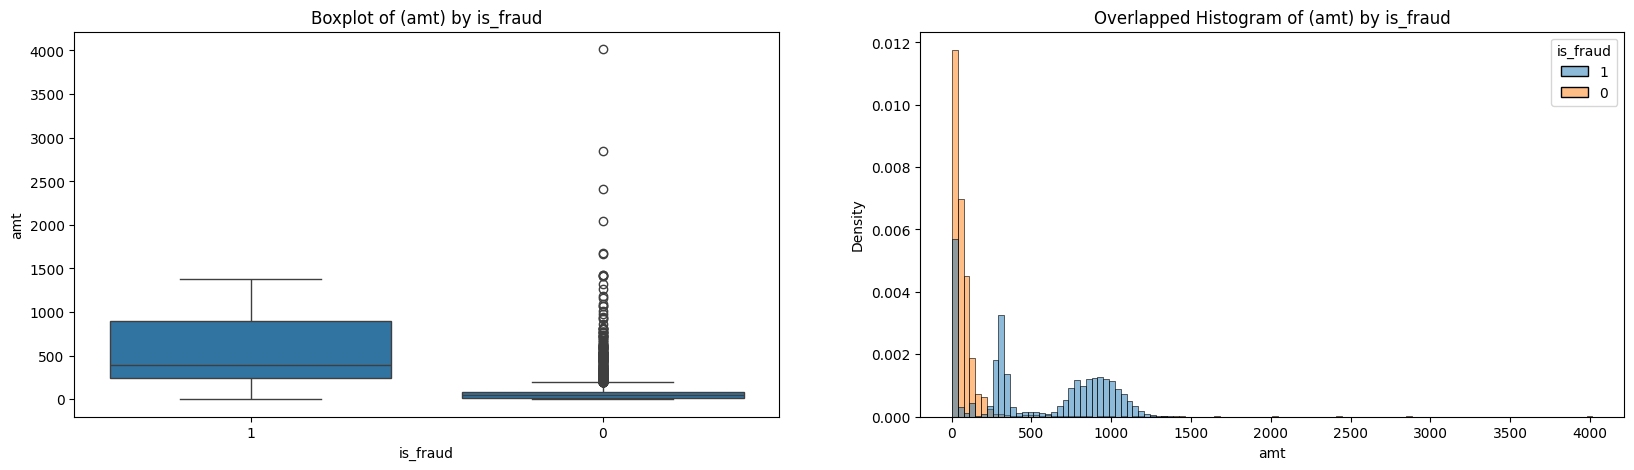

In [38]:
# Check the historam between amt and the classes in is_fraud
plt.figure(figsize=(20, 5))

# First subplot for the boxplot
plt.subplot(1, 2, 1)
sns.boxplot(data=balanced_pd, x="is_fraud", y="amt")
plt.title(f"Boxplot of (amt) by is_fraud")

# Second subplot for the histogram
plt.subplot(1,2,2)
sns.histplot(data=balanced_pd, x="amt", hue="is_fraud", stat="density", common_norm=False)
plt.title(f"Overlapped Histogram of (amt) by is_fraud")

plt.show()

Observation: 
- For non-fraud transactions (is_fraud = 0), most non-fraud transactions are small in amount and numerous outliers with high transaction values. Very skewed distribution > a heavy right tail with large values occuring less frequently
- For fraudulent transactions (is_fraud = 1), the transactions tend to involve higher average amounts with median amount significantly higher than non-fraud cases. Peaks in mid-to-high value transacations (ranges from 300-400 or 800-1000s)

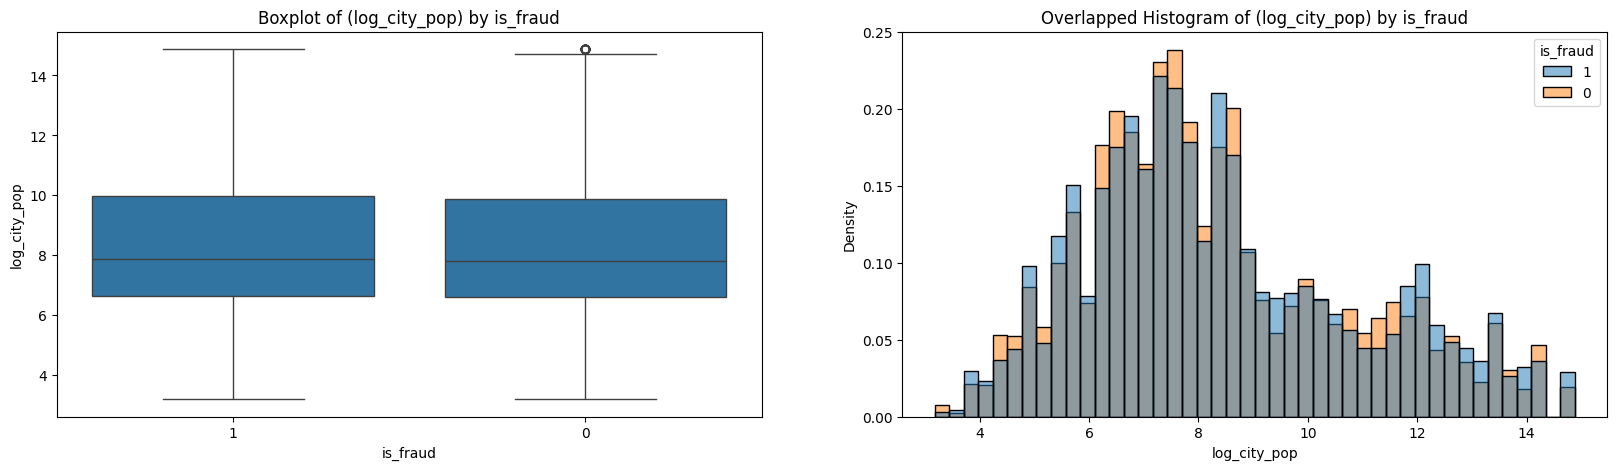

In [39]:
# Log scaling for the city_pop field because the distribution is too skewed for easier view on the distribition
balanced_pd['log_city_pop'] = np.log1p(balanced_pd['city_pop'])

#  Check the historam between amt and the classes in is_fraud
plt.figure(figsize=(20, 5))

# First subplot for the boxplot
plt.subplot(1, 2, 1)
sns.boxplot(data=balanced_pd, x="is_fraud", y="log_city_pop")
plt.title(f"Boxplot of (log_city_pop) by is_fraud")

# Second subplot for the histogram
plt.subplot(1,2,2)
sns.histplot(data=balanced_pd, x="log_city_pop", hue="is_fraud", stat="density", common_norm=False)
plt.title(f"Overlapped Histogram of (log_city_pop) by is_fraud")

plt.show()

Observation
- Both fraudulent and non-fraudulent transactions have similar medians and IQRs. There seems to be slighter more fraudulent transactions in higher city populations although the distribution between the two classes are similar

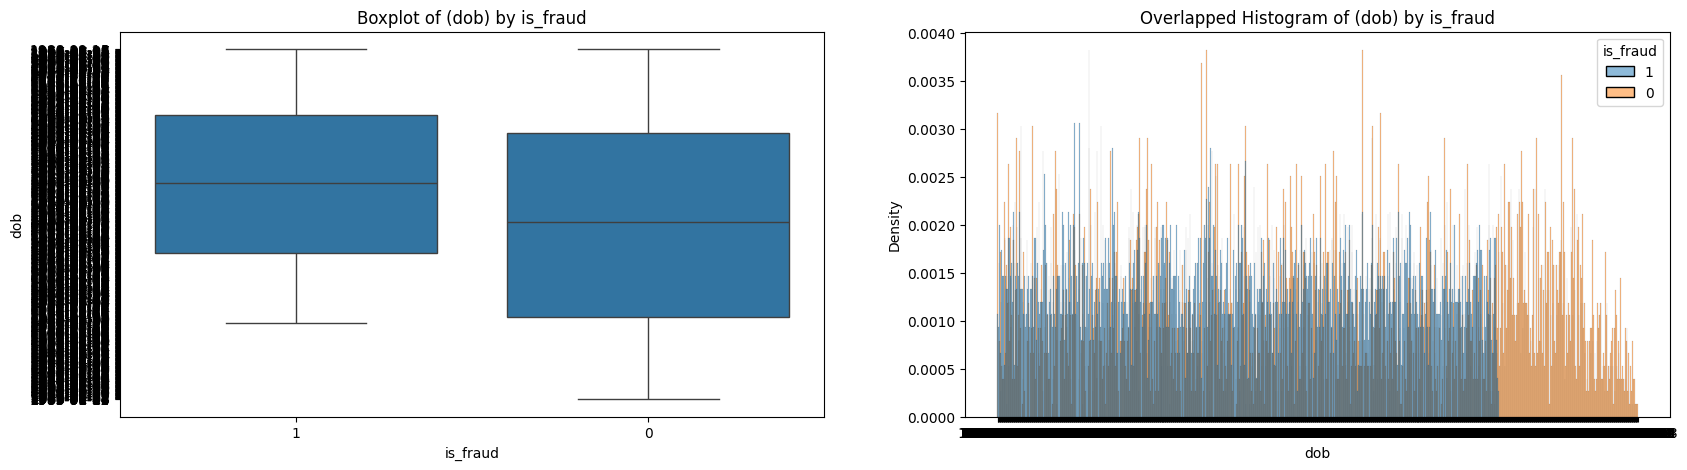

In [40]:
# Check the historam between amt and the classes in is_fraud
plt.figure(figsize=(20, 5))

# First subplot for the boxplot
plt.subplot(1, 2, 1)
sns.boxplot(data=balanced_pd, x="is_fraud", y="dob")
plt.title(f"Boxplot of (dob) by is_fraud")

# Second subplot for the histogram
plt.subplot(1,2,2)
sns.histplot(data=balanced_pd, x="dob", hue="is_fraud", stat="density", common_norm=False)
plt.title(f"Overlapped Histogram of (dob) by is_fraud")

plt.show()

Observation
- The median for the fraudulent transactions is higher - suggesting the age of perpetrator is usually younger. Based on the histogram, the fraudulent transactions tends to skew to younger age as well

## Categorical Columns

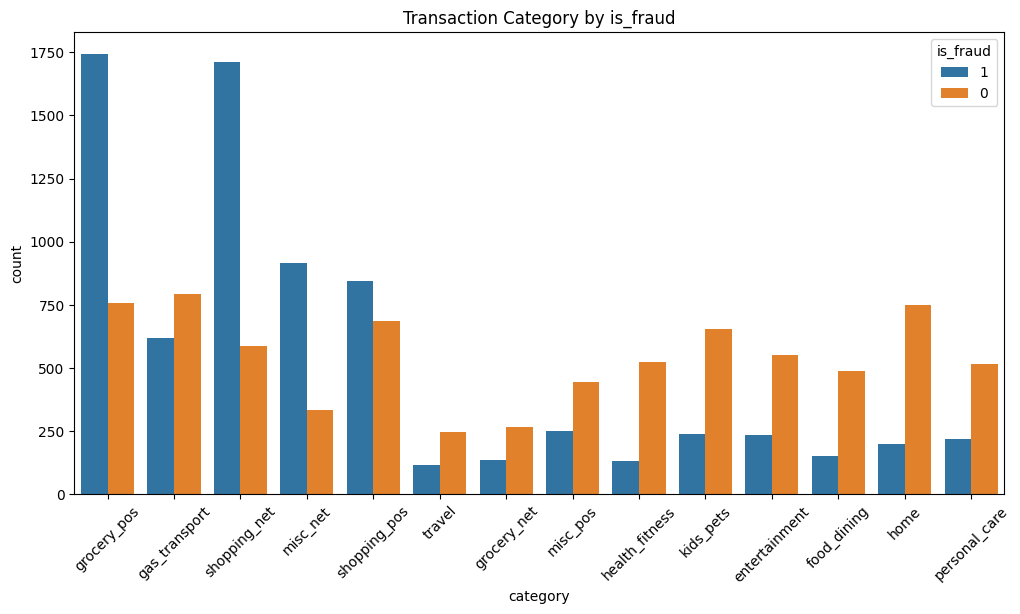

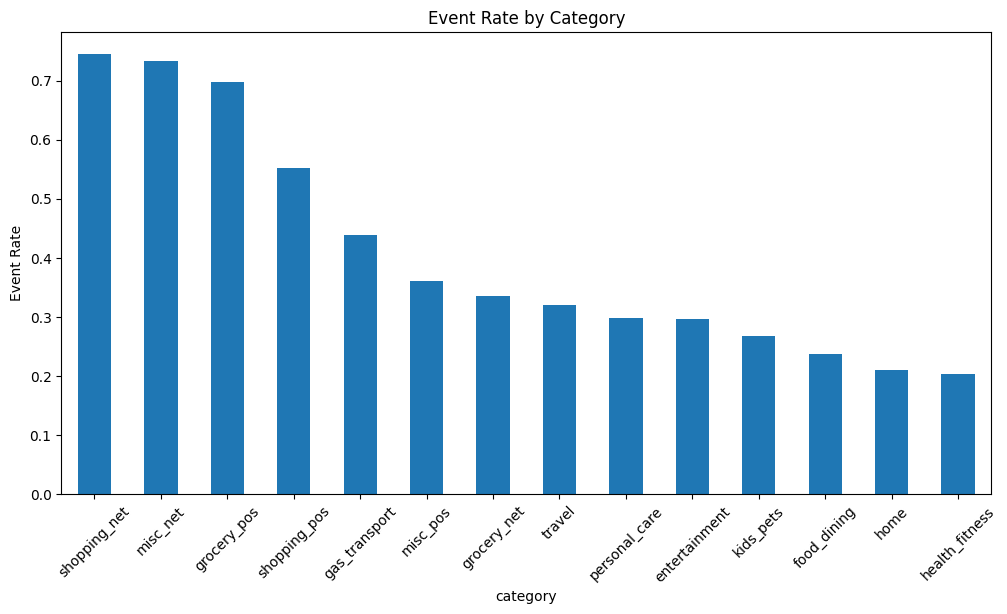

In [41]:
plt.figure(figsize=(12,6))
sns.countplot(data=balanced_pd, x='category', hue='is_fraud')
plt.xticks(rotation=45)
plt.title('Transaction Category by is_fraud')
plt.show()

agg_category_by_is_fraud = (
    balanced_pd
    .assign(is_fraud_num = balanced_pd["is_fraud"].astype(int))
    .groupby("category")["is_fraud_num"]
    .mean()
    .sort_values(ascending=False)
)

agg_category_by_is_fraud.plot(kind='bar', figsize=(12, 6))
plt.ylabel("Event Rate")
plt.title("Event Rate by Category")
plt.xticks(rotation=45)
plt.show()

Observation
- Specific categories (like shopping_net, misc_net grocery_pos, shopping_post) have higher ratios of fraudulent transactions (is_fraud = 1)
Note: Event Rate higher than 0.5 indicates the number of the fraudulent transactions is higher than the non-fraudulent transactions

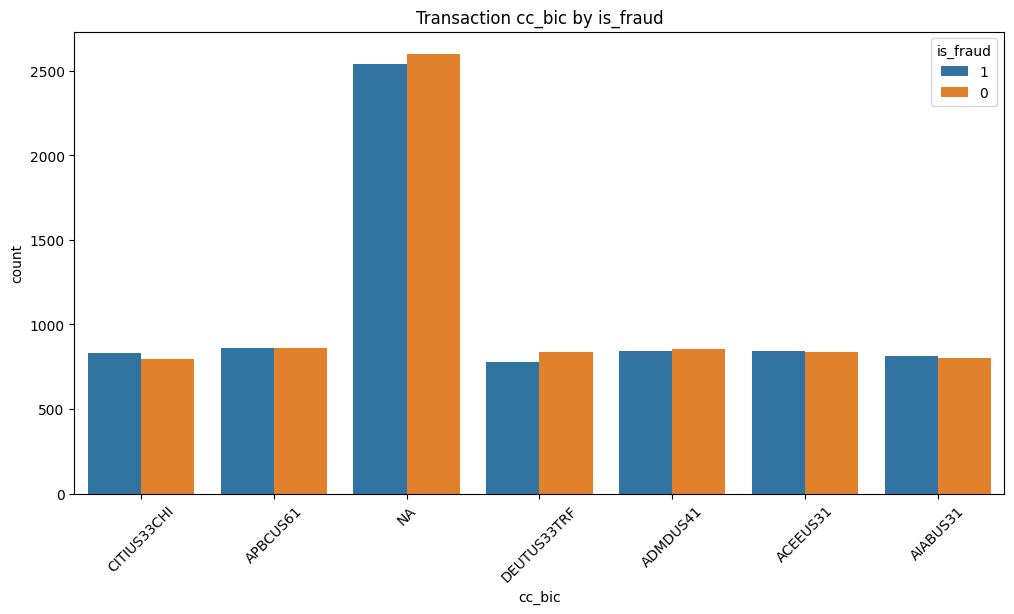

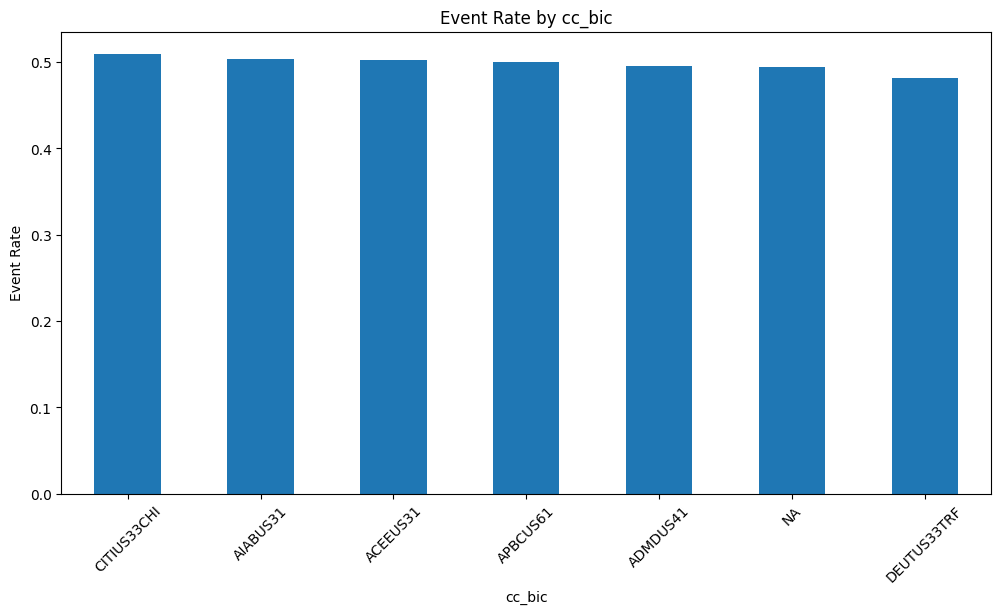

In [42]:
plt.figure(figsize=(12,6))
sns.countplot(data=balanced_pd, x='cc_bic', hue='is_fraud')
plt.xticks(rotation=45)
plt.title('Transaction cc_bic by is_fraud')
plt.show()

agg_cc_bic_by_is_fraud = (
    balanced_pd
    .assign(is_fraud_num = balanced_pd["is_fraud"].astype(int))
    .groupby("cc_bic")["is_fraud_num"]
    .mean()
    .sort_values(ascending=False)
)

agg_cc_bic_by_is_fraud.plot(kind='bar', figsize=(12, 6))
plt.ylabel("Event Rate")
plt.title("Event Rate by cc_bic")
plt.xticks(rotation=45)
plt.show()

Observation
- Class distribution between fraud and non-fraud distribution seems balanced between the categories. 

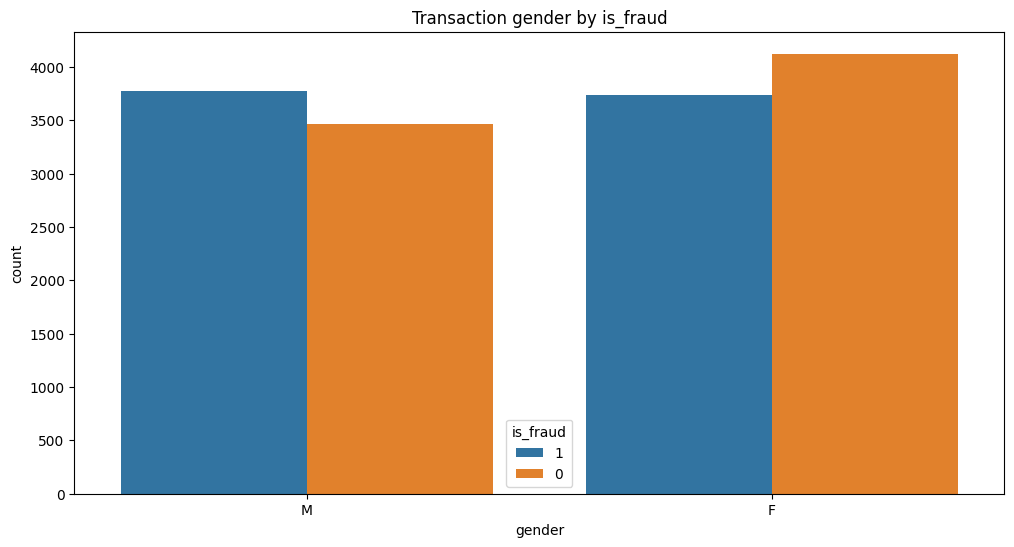

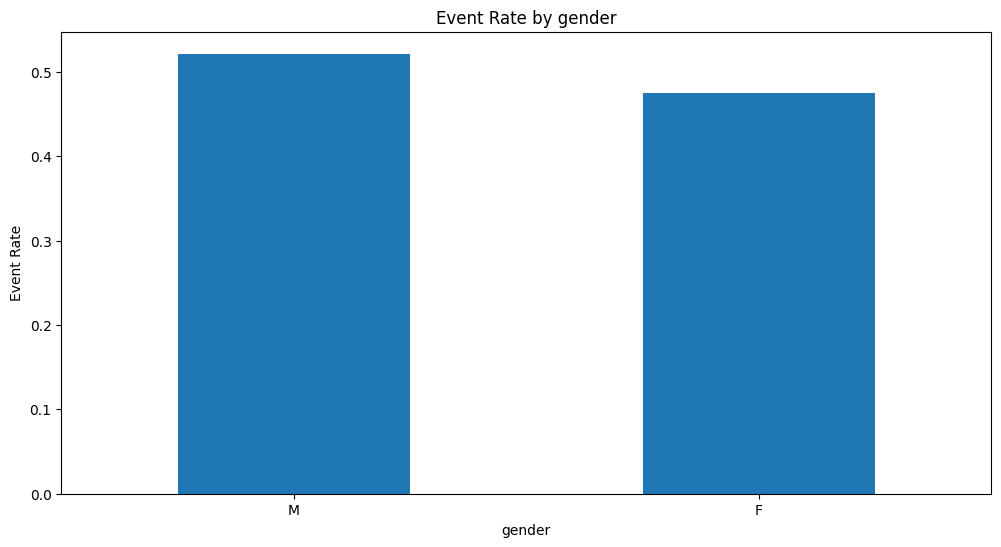

In [43]:
plt.figure(figsize=(12,6))
sns.countplot(data=balanced_pd, x='gender', hue='is_fraud')
plt.xticks(rotation=0)
plt.title('Transaction gender by is_fraud')
plt.show()

agg_gender_by_is_fraud = (
    balanced_pd
    .assign(is_fraud_num = balanced_pd["is_fraud"].astype(int))
    .groupby("gender")["is_fraud_num"]
    .mean()
    .sort_values(ascending=False)
)

agg_gender_by_is_fraud.plot(kind='bar', figsize=(12, 6))
plt.ylabel("Event Rate")
plt.title("Event Rate by gender")
plt.xticks(rotation=0)
plt.show()

Observation
- Similar to cc_bic - Class distribution between fraud and non-fraud distribution seems balanced between the categories. 

## Correlation

               amt  city_pop  is_fraud
amt       1.000000  0.023255  0.626234
city_pop  0.023255  1.000000  0.019301
is_fraud  0.626234  0.019301  1.000000


<Figure size 1500x800 with 0 Axes>

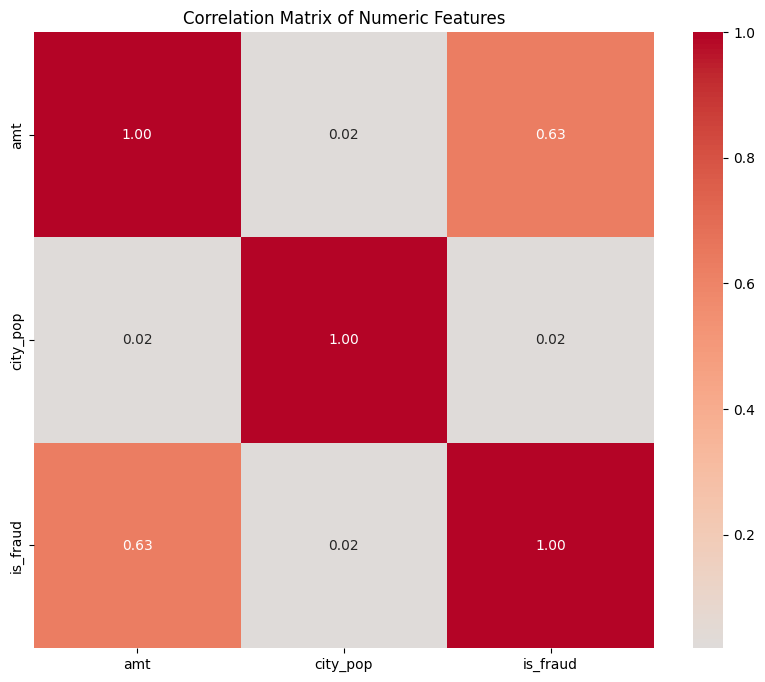

In [44]:
plt.figure(figsize=(15, 8))

# Select numeric columns only (e.g. including 'is_fraud')
numeric_df = balanced_pd.loc[:, ["amt", "city_pop", "is_fraud"]]

# Compute correlation matrix
corr_matrix = numeric_df.corr()

print(corr_matrix)

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", center=0)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

Observation
- The amt field have a moderate positive correlation to the is_fraud field - which suggests higher transaction amounts associated with fraudulent transactions

# 7. Fraud Risk Scenarios

## Check if One Person Has Multiple Credit Cards
- Suspicious if a person has many cards not consistent with typical behavior

In [45]:
# Check for 
agg_person = dim_df.groupby("person_id").agg(
    countDistinct("cc_id").alias("count_distinct_cc_id"), 
    count("cc_id").alias("count_cc_id_transaction")
).sort(desc("count_distinct_cc_id"))
agg_person.show()

+--------------------+--------------------+-----------------------+
|           person_id|count_distinct_cc_id|count_cc_id_transaction|
+--------------------+--------------------+-----------------------+
|cfa9abd07cf19e70d...|                   1|                   1037|
|48fb31df56031112a...|                   1|                   2063|
|68b434b6aafb5e3aa...|                   1|                    510|
|9a22fe262004bc3a4...|                   1|                   1535|
|f2ba11a6cb8ddcb62...|                   1|                   1029|
|7d27fa98a77a33eff...|                   1|                     11|
|135e75523242811f1...|                   1|                      7|
|8bcaf4967ff4e466c...|                   1|                    520|
|56c922d5d55d91ddb...|                   1|                   1530|
|9cc5746b8e72ded02...|                   1|                    516|
|e53e21dc51d096aa4...|                   1|                   1046|
|88cdfd82aff23bb95...|                   1|     

Observation
- Seems like the dataset is clean with one cc_id associated to one unique person_id only (person name + date of birth). 

## Check if One Credit Card Used by Multiple Persons
- Could indicate stolen or shared card

In [46]:
agg_cc_id = dim_df.groupby("cc_id").agg(
    countDistinct("person_id").alias("count_distinct_person_id"), 
    count("person_id").alias("count_person_id_transaction")
).sort(desc("count_distinct_person_id"))
agg_cc_id.show()

+--------------------+------------------------+---------------------------+
|               cc_id|count_distinct_person_id|count_person_id_transaction|
+--------------------+------------------------+---------------------------+
|65a4b6b9981529af1...|                       1|                        504|
|cc0cb46fe1dfcf015...|                       1|                       2082|
|1a4efe66e90a855f7...|                       1|                       2523|
|c0f13035aa4e69e93...|                       1|                       2572|
|65e35541e7862a61e...|                       1|                       1523|
|ca841600a2d4d90b9...|                       1|                        511|
|de192b163372e341a...|                       1|                       1022|
|606d0d82d018b23c7...|                       1|                       1538|
|eebfe7692ce9dac4e...|                       1|                       3119|
|7dbe5ab7dad497d8b...|                       1|                       1577|
|5110e3f6573

Observation
- Similarly to the person_id - for every unique cc_id, there is only one distinct person_id using it.

## Check if multiple zip codes used by One Person

In [47]:
dim_df.groupBy("person_id").agg(countDistinct("zip").alias("count")).filter("count > 1").show()

+---------+-----+
|person_id|count|
+---------+-----+
+---------+-----+



Observation
- No person_id with more than one zip codes observed

## Check for Transactions from Distant Locations in Short Time (a.k.a. "Impossible Travel")
- transactions (non-online transactions; categories without "_net" suffix) are performed > 200km within 1 hour time difference

In [48]:
window_spec = Window.partitionBy("cc_id").orderBy("trans_date_trans_time")

# Create lag columns for time and location
df_distance = (
    # Filter out category of transactions that have suffix "_net" as online transactions can happen for different merchant location within small window of time
    dim_df.filter(~col("category").contains("_net")).withColumn("prev_time", lag("trans_date_trans_time").over(window_spec))
    .withColumn("prev_lat", lag("merch_lat").over(window_spec))
    .withColumn("prev_long", lag("merch_long").over(window_spec))
)
# Calculate time difference in hours
df_distance = df_distance.withColumn(
    "time_diff_hr",
    (unix_timestamp("trans_date_trans_time") - unix_timestamp("prev_time")) / 3600.0,
)

# Calculate Haversine distance between previous and current lat/long
# Convert degrees to radians
df_distance = df_distance.withColumn("lat1", radians(col("prev_lat"))) \
       .withColumn("lon1", radians(col("prev_long"))) \
       .withColumn("lat2", radians(col("merch_lat"))) \
       .withColumn("lon2", radians(col("merch_long")))

# Compute deltas
df_distance = df_distance.withColumn("dlat", col("lat2") - col("lat1")) \
       .withColumn("dlon", col("lon2") - col("lon1"))

# Haversine formula
df_distance = df_distance.withColumn("a", sin(col("dlat")/2)**2 +
                         cos(col("lat1")) * cos(col("lat2")) * sin(col("dlon")/2)**2)

df_distance = df_distance.withColumn("c", 2 * atan2(sqrt(col("a")), sqrt(1 - col("a"))))

df_distance = df_distance.withColumn("distance_km", lit(6371.0) * col("c"))  # Earth radius

# Flag suspicious transactions (where speed > 1000 km/h and time_diff_hr > 0)
df_distance_flagged = df_distance.filter(
    (col("distance_km") > 200) &
    (col("time_diff_hr") < 1)
)

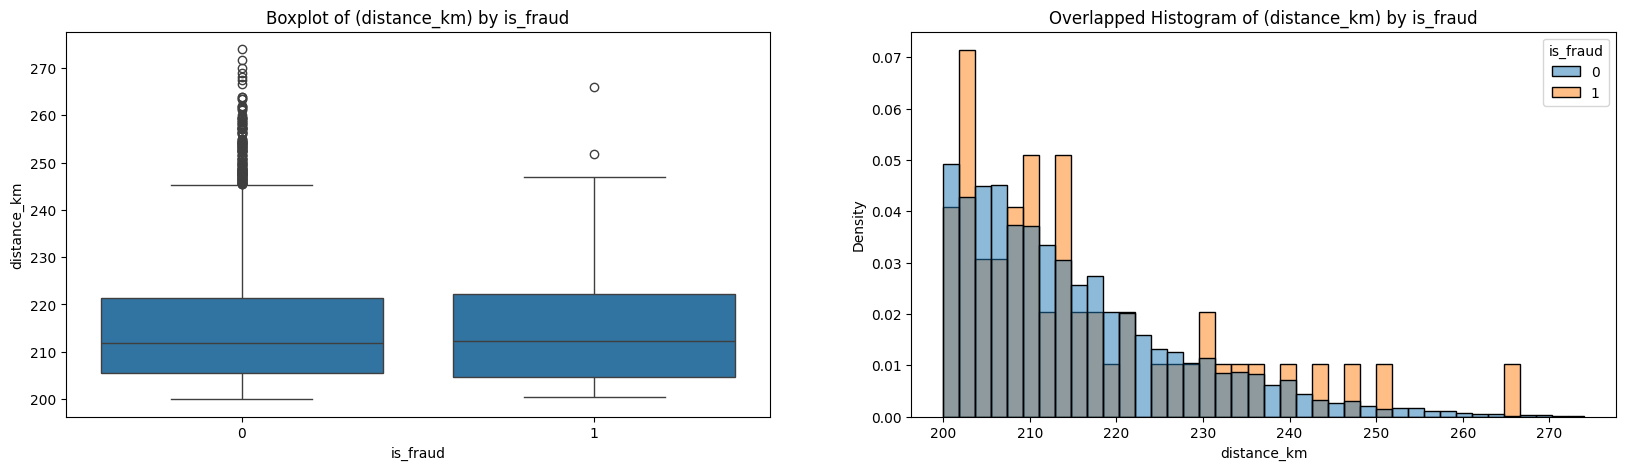

In [49]:
data_flagged_pd = df_distance_flagged.select(
    "cc_id",
    "category",
    "merch_lat",
    "merch_long",
    "prev_lat",
    "prev_long",
    "time_diff_hr",
    "lat1",
    "lon1",
    "lat2",
    "lon2",
    "dlat",
    "dlon",
    "a",
    "c",
    "distance_km",
    "trans_date_trans_time",
    "prev_time",
    "time_diff_hr",
    "is_fraud",
).sort("cc_id").toPandas()

#  Check the histogram between amt and the classes in is_fraud
plt.figure(figsize=(20, 5))

# First subplot for the boxplot
plt.subplot(1, 2, 1)
sns.boxplot(data=data_flagged_pd, x="is_fraud", y="distance_km")
plt.title(f"Boxplot of (distance_km) by is_fraud")

# Second subplot for the histogram
plt.subplot(1,2,2)
sns.histplot(data=data_flagged_pd, x="distance_km", hue="is_fraud", stat="density", common_norm=False)
plt.title(f"Overlapped Histogram of (distance_km) by is_fraud")

plt.show()

Observation
- With the additional flag based on "distance_km" > 200KM (current transaction merch_lat & merch_long vs previous merch_lat & merch_long), we can see that fraudulent transactions are usually associated with slightly higher distances although we can observe that there is significant overlap between the two classes which may not be sufficient to be considered as a flag

## Check if there's high frequency of transactions in short time

In [50]:
# Sample schema: cc_id (string), trans_date_trans_time (timestamp), amount (double), etc.
# Assume `df` is your input DataFrame
# Ensure timestamp is in correct format
data = dim_df.withColumn("trans_time", col("trans_date_trans_time").cast("timestamp"))

# Create 5-minute tumbling windows for each card
agg_cc_id_by_trans_time = data.groupBy(
    col("cc_id"),
    window(col("trans_time"), "5 minutes")
).agg(
    count("*").alias("txn_count")
)

# Filter: Only keep windows with high frequency (e.g., >=3 transactions in 5 min)
high_frequency_tnx_df = agg_cc_id_by_trans_time.filter(col("txn_count") >= 3)
high_frequency_tnx_df.show(truncate=False)
print(f"There are {high_frequency_tnx_df.count()} cc_id with high frequency transactions (>=3) within 5 minutes")


+----------------------------------------------------------------+------------------------------------------+---------+
|cc_id                                                           |window                                    |txn_count|
+----------------------------------------------------------------+------------------------------------------+---------+
|0f1d9f6cc7b31667e55399f24f85d259826ca2e4e0ecb848b4905f40a566f65f|{2019-05-24 17:10:00, 2019-05-24 17:15:00}|3        |
|dcfb76f953e2bc2b89df3c6f7ffae957a65431082d4fb7345d8633295a273b49|{2019-11-15 19:30:00, 2019-11-15 19:35:00}|3        |
|42703b2c21ce906dcff358f290625941099c0e27d95e3349e569e355a6ccc7fc|{2019-12-29 16:55:00, 2019-12-29 17:00:00}|3        |
|e432763e8aa232b762ff061a823ce062521848ed7c97294f394099920772f07d|{2019-09-16 06:35:00, 2019-09-16 06:40:00}|3        |
|1a78ec2e2cecbaef6fc6b3c145832bf2bfb6f822ba513a2db2a3b164129ee83e|{2019-12-02 15:45:00, 2019-12-02 15:50:00}|3        |
|1d5868e1d1c51ef06cc83bab6a058383a08c4e6

There are 79 cc_id with high frequency transactions (>=3) within 5 minutes


## Check for Anomaly - Transactions 2x above P99 by categories

In [51]:
# Compute 99th percentile per category
agg_category_99th_percentile = dim_df.groupBy("category").agg(
    expr("percentile_approx(amt, 0.99)").alias("p99")
)

# Join back to original to get 99th percentile per row
df_with_p99 = dim_df.join(agg_category_99th_percentile, on="category", how="left")

# Flag anomalies where amt > 2 * p90
tnx_2x_above_p99 = df_with_p99.withColumn(
    "is_anomaly",
    when(col("amt") > 2 * col("p99"), lit(1)).otherwise(lit(0))
)

# Filter df by anomalies
flagged_tnx_2x_above_p99_df = tnx_2x_above_p99.filter("is_anomaly = 1")

# Show flagged anomalies
flagged_tnx_2x_above_p99_df.select("trans_date_trans_time", "category", "amt", "p99", "is_anomaly").show()
print(f"There are {flagged_tnx_2x_above_p99_df.count()} records for transactions 2x above 99th percentile of the category")

+---------------------+--------+-------+------+----------+
|trans_date_trans_time|category|    amt|   p99|is_anomaly|
+---------------------+--------+-------+------+----------+
|  2019-01-11 16:52:03|misc_net| 2116.9|845.48|         1|
|  2019-03-04 19:35:43|misc_net|2229.67|845.48|         1|
|  2019-04-19 10:11:05|misc_net|2270.14|845.48|         1|
|  2019-04-21 21:37:02|misc_net|4084.34|845.48|         1|
|  2019-06-05 04:09:07|misc_net|1983.65|845.48|         1|
|  2019-07-25 07:01:12|misc_net|1830.45|845.48|         1|
|  2019-08-13 04:40:52|misc_net|2023.82|845.48|         1|
|  2019-08-18 18:34:17|misc_net|1716.94|845.48|         1|
|  2019-08-29 02:03:38|misc_net|1752.43|845.48|         1|
|  2019-09-08 08:14:59|misc_net|1813.05|845.48|         1|
|  2019-09-21 05:54:17|misc_net|1896.85|845.48|         1|
|  2019-10-14 11:02:17|misc_net|1892.71|845.48|         1|
|  2019-10-22 06:01:59|misc_net|2863.71|845.48|         1|
|  2019-11-04 10:53:08|misc_net| 1818.3|845.48|         

## Check if Merchant Location Matches User Location
- Large distances between user and merchant may indicate fraud, especially if it happens frequently.

In [52]:
# Convert degrees to radians
df_with_locations = dim_df.withColumn("lat_rad", radians(col("lat"))) \
       .withColumn("long_rad", radians(col("long"))) \
       .withColumn("merch_lat_rad", radians(col("merch_lat"))) \
       .withColumn("merch_long_rad", radians(col("merch_long")))

# Haversine formula
df_with_locations = df_with_locations.withColumn("dlat", col("merch_lat_rad") - col("lat_rad")) \
       .withColumn("dlon", col("merch_long_rad") - col("long_rad")) \
       .withColumn("a", sin(col("dlat")/2)**2 + cos(col("lat_rad")) * cos(col("merch_lat_rad")) * sin(col("dlon")/2)**2) \
       .withColumn("c", 2 * atan2(sqrt(col("a")), sqrt(1 - col("a")))) \
       .withColumn("distance_km", 6371 * col("c")) # R = Earth's radius in kilometers

# Flag transactions where distance > threshold (e.g., 1000 km)
df_with_locations = df_with_locations.withColumn("location_mismatch", (col("distance_km") > 1000).cast("int"))

df_with_locations_mismatch = df_with_locations.filter(col("location_mismatch")==1)
# Show mismatches
df_with_locations_mismatch.select("lat", "long", "merch_lat", "merch_long", "distance_km", "location_mismatch").show()
print(f"There are {df_with_locations_mismatch.count()} records with distance mismatch between person_id and merch")


+---+----+---------+----------+-----------+-----------------+
|lat|long|merch_lat|merch_long|distance_km|location_mismatch|
+---+----+---------+----------+-----------+-----------------+
+---+----+---------+----------+-----------+-----------------+

There are 0 records with distance mismatch between person_id and merch
